In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re 
import seaborn as sns
import math 
import collections
from pycocotools.coco import COCO
import requests
import plotly.express as px
from jupyter_dash import JupyterDash
from dash import Dash, dcc, html, Input, Output, no_update
import plotly.graph_objects as go
from os import listdir
from os.path import isfile, join
import base64
import itertools
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)
sns.set(style='whitegrid', font_scale=1.6, font='Georgia', context='paper')

from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import operator
import plotly.figure_factory as ff
import scipy
import pickle 

/tmp/ipykernel_10353/1105818520.py:21: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


# Plot datamaps

In [2]:
def load_datamap_stats(base_path):
    '''
    Returns datamap stats recorded during training split by epochs

            Parameters:
                    base_path (str): Path to model metadata

            Returns:
                    df (DataFrame): Pandas dataframe with datamap stats: 
                                    confidence, variability and correctness
    '''
    # load logged stats from training 
    with open(base_path + 'datamaps_stats.json') as fp:
        datamap_stats_raw = json.load(fp)

    result = collections.defaultdict(list)
    for stat in datamap_stats_raw:
        result[stat['Epoch']].append(stat)
    datamap_stats = list(result.values())
    #datamap_stats = list(datamap_stats.values())

    return datamap_stats

def preprocess_multilabel_datamaps_stats(stats):
    preprocessed_stats = []
    for epoch_stats in stats:
        epoch_stats_preprocessed = []
        for example in epoch_stats:
            target_list = [x.strip() for x in example['Target'].split(',')]
            if len(target_list) > 1:
                probability_list = list(map(float, example['GT Probability'].split(',')))
                max_prob = max(probability_list)
                max_prob_idx = probability_list.index(max(probability_list))
                # max_prob_target = target_list[max_prob_idx]
                # example['Target'] = max_prob_target.strip()
                # print(example['Target'])
                #example['Target'] = target_list
                example['GT Probability'] = max_prob
                epoch_stats_preprocessed.append(example)
            elif len(target_list) == 1:
                if target_list[0] != '':
                    epoch_stats_preprocessed.append(example)
                else:
                    continue
            else:
                continue
        preprocessed_stats.append(epoch_stats_preprocessed)
    return preprocessed_stats

            


def calc_confidence(df_probabilities):
    '''Calculates confidence by taking the mean for each instance probability at ground truth over all epochs'''
    x = np.array(df_probabilities['Probabilities'].tolist())
    confidence = np.mean(x.astype(float), axis=1)
    return confidence

def calc_variance(df_probabilities):
    '''Calculates variance by taking the standard deviation for each instance probability at ground truth over all epochs'''
    x = np.array(df_probabilities['Probabilities'].tolist())
    variance = np.std(x.astype(float), axis=1)
    return variance

def calc_correctness(df_correct_preds):
    '''Calculates correctness by measuring the number of times prediction == target'''
    x = np.array(df_correct_preds['Corrects'].tolist())
    boolean_array = (x=='True')
    sums = np.sum(boolean_array, axis=1)
    correctness = sums/len(df_correct_preds.loc[0]['Corrects'])
    return correctness

def remove_duplicates(id_probs, probs_corrects, col_name):
    predictions = pd.DataFrame(list(zip(id_probs.keys(), probs_corrects)), columns =['Question ID', col_name])
    predictions_duplicate = predictions[col_name].values
    predictions_remove_duplications = []
    for pred in predictions_duplicate:
        update = list(set(pred))
        if col_name != 'Predictions':
            if len(update) != 1:
                print(col_name)
                print(update)
                print("INVALID")
        predictions_remove_duplications.append(list(set(pred)))
    predictions[col_name] = predictions_remove_duplications
    return predictions

def datamap_metrics(datamap_stats, correctness_check=False, multilabel=False):
    '''
    Returns dataframe with confidence, correctness and variability for datamap plotting

            Parameters:
                    datamap_stats (list): List of instance metadata for datamap 
                                          generation bucketed by epoch

            Returns:
                    df (DataFrame): Pandas dataframe with datamap metrics and question ids
    '''
    coco_train = COCO('../src/dataset_selection/datamaps/coco/annotations/instances_train2014.json')
    coco_val = COCO('../src/dataset_selection/datamaps/coco/annotations/instances_val2014.json')
    ids_probs = {}
    for example in datamap_stats[0]:
        ids_probs[example['Question ID']]=([],[],[],[],[],[]) # probabilities, corrects, question, target, prediction, image_id

    for epoch_instances in datamap_stats:
        for example in epoch_instances:
            if multilabel == True:
                if example['Prediction'] in example['Target']:
                    correct = True
                else:
                    correct = False
            else:
                if example['Target'] == 'geese' and example['Prediction'] == 'goose': # special case in animal split
                    correct = True
                elif example['Prediction'][-1] == 's' and example['Prediction'][-1] == example['Target']: # account for plurals in animal split
                    correct = True
                elif example['Target'] == example['Prediction']:
                    correct = True
                else:
                    correct = False
            ids_probs[example['Question ID']][0].append(example['GT Probability'])
            ids_probs[example['Question ID']][1].append(correct)
            ids_probs[example['Question ID']][2].append(example['Question'])
            ids_probs[example['Question ID']][3].append(example['Target'])
            ids_probs[example['Question ID']][4].append(example['Prediction'])
            ids_probs[example['Question ID']][5].append(example['Image ID'])

    probs_corrects = np.array(list(ids_probs.values()))
    probabilities = pd.DataFrame(list(zip(ids_probs.keys(), probs_corrects[:, 0, :])),
                columns =['Question ID', 'Probabilities'])

    corrects = pd.DataFrame(list(zip(ids_probs.keys(), probs_corrects[:, 1, :])),
                columns =['Question ID', 'Corrects'])

    predictions = remove_duplicates(ids_probs, probs_corrects[:, 4, :], 'Predictions')
    questions = remove_duplicates(ids_probs, np.squeeze(probs_corrects[:, 2, :]), 'Question')
    targets = remove_duplicates(ids_probs, np.squeeze(probs_corrects[:, 3, :]), 'Target')
    image_ids = remove_duplicates(ids_probs, np.squeeze(probs_corrects[:, 5, :]), 'Image ID')
    ids_list = image_ids['Image ID']
    img_urls = []
    for img in ids_list:
        assert len(img) == 1
        id_str = str(img[0])
        if 'val' in id_str:
            loaded_img = coco_val.loadImgs([int(id_str[-6:])])
        else:
            loaded_img = coco_train.loadImgs([int(id_str[-6:])])
        
        assert len(loaded_img) == 1
        img_urls.append(loaded_img[0]['coco_url'])

    confidence_score = calc_confidence(probabilities)
    variance_score = calc_variance(probabilities)
    correctness_score = calc_correctness(corrects)

    d= {"confidence": np.squeeze(confidence_score), "variability": np.squeeze(variance_score), "correctness":correctness_score, "question_id":probabilities['Question ID'],
        "Predictions": predictions['Predictions'], "Question":questions['Question'], "Target":targets['Target'], "Image ID":ids_list, "Image URL":img_urls}
    df= pd.DataFrame(d)

    if correctness_check == True:
        low_correctness_high_confidence = df.loc[(df['correctness'] < 0.4) & (df['confidence'] > 0.8)]

        ids = low_correctness_high_confidence.index

        for id in ids:  
            x = probabilities.loc[id]
            y = corrects.loc[id]

            d_exp = {'probabilities':x, 'correctness': y}
            df_exp = pd.DataFrame(data=d)
            print(df_exp)

    return df


def calculate_datamap_metrics(base_path, multilabel):
    if multilabel == True:
        print("MULTILABEL")
        datamap_stats = load_datamap_stats(base_path)
        preprocessed = preprocess_multilabel_datamaps_stats(datamap_stats)
        df = datamap_metrics(preprocessed, multilabel=True)
        #df.to_pickle(base_path+'datamap_metrics.pkl')
        return df

    else:
        datamap_stats = load_datamap_stats(base_path)
        df = datamap_metrics(datamap_stats)
        #df.to_pickle(base_path+'datamap_metrics.pkl')
        return df
    

In [3]:
def scatter_it_interactive(dataframe, base_path, hue_metric ='correct.', title='', model='LXMERT', show_hist=False):

    dataframe['correct.'] = dataframe['correctness']
    
    main_metric = 'variability'
    other_metric = 'confidence'
    
    hue = hue_metric
    num_hues = len(dataframe[hue].unique().tolist())
    style = hue_metric if num_hues < 8 else None

    # if not show_hist:
    #     fig, axs = plt.subplots(1, 1, figsize=(8, 4))
    #     ax0 = axs
    # else:
    #     fig = plt.figure(figsize=(16, 10), )
    #     gs = fig.add_gridspec(2, 3, height_ratios=[5, 1])
    
    #     ax0 = fig.add_subplot(gs[0, :])
    
    
    # ### Make the scatterplot.
    # fig = px.scatter(dataframe, x=main_metric,
    #                        y=other_metric, 
    #                        color=hue,
    #                        symbol=style,
    #                        size_max=30)
    # fig.show()

    fig = go.Figure(data=[
        go.Scatter(
            x=dataframe[main_metric],
            y=dataframe[other_metric],
            mode="markers",
            marker=dict(
                colorscale='viridis',
                color=dataframe[hue],
                colorbar={"title": "Correctness"},
                line={"color": "#444"},
                reversescale=True,
                sizeref=45,
                sizemode="diameter",
                opacity=0.8,
            ),
        )
    ])

    # fig = go.Figure(data=[
    #     px.scatter(dataframe, x=main_metric, y=other_metric, color=hue)
    # ])

    # turn off native plotly.js hover effects - make sure to use
    # hoverinfo="none" rather than "skip" which also halts events.
    fig.update_traces(hoverinfo="none", hovertemplate=None)

    fig.update_layout(
        xaxis=dict(title=main_metric),
        yaxis=dict(title=other_metric),
        plot_bgcolor='rgba(255,255,255,0.1)',
        title = title
    )

    fig2 = make_subplots(rows=1, cols=3, subplot_titles=('Confidence', 'Variability', 'Correctness'))
    fig2.add_trace(go.Histogram(histfunc="count", x=dataframe["confidence"]), row=1, col=1)
    fig2.add_trace(go.Histogram(histfunc="count", x=dataframe["variability"]), row=1, col=2)
    fig2.add_trace(go.Histogram(histfunc="count", x=dataframe["correct."]), row=1, col=3)


    fig2.update_layout(yaxis_title='Density', showlegend=False)

    #app = JupyterDash(__name__)
    app = Dash(__name__)


    app.layout = html.Div([
        html.H1(children=title),
        dcc.Graph(id="graph", figure=fig, clear_on_unhover=True),
        dcc.Tooltip(id="graph-tooltip"),
        dcc.Graph(id="graph2", figure=fig2),
    ])


    @app.callback(
        Output("graph-tooltip", "show"),
        Output("graph-tooltip", "bbox"),
        Output("graph-tooltip", "children"),
        Input("graph", "hoverData"),
    )

    def display_hover(hoverData):
        if hoverData is None:
            return False, no_update, no_update

        # demo only shows the first point, but other points may also be available
        pt = hoverData["points"][0]
        bbox = pt["bbox"]
        num = pt["pointNumber"]

        df_row = dataframe.iloc[num]
        variability = df_row['variability']
        confidence = df_row['confidence']
        correctness = df_row['correctness']
        predictions = df_row['Predictions']
        question = df_row['Question']
        target = df_row['Target']
        img_src = df_row['Image URL']
        
        #if len(desc) > 300: desc = desc[:100] + '...'
        # image_id = str(df_row['Image ID'][0])
        # if 'val' in image_id:
        #     split = 'validation'
        #     image = coco_val.loadImgs([int(image_id[-6:])])
        # else:
        #     split = 'train'
        #     image = coco_train.loadImgs([int(image_id[-6:])])

        # if len(image) == 1:
        #     img_src = image[0]['coco_url']

        #image = '../../fiftyone/coco-2014/'+split+'/data/'+image_id + '.jpg'
        #encoded_image = base64.b64encode(open(image, 'rb').read())

        children = [
            html.Div(children=[
                html.Img(src=img_src, style={"width": "100%"}),
                html.P(f"Question: {question}"),
                html.P(f"Target: {target}"),
                html.P(f"Predictions: {predictions}"),
                html.P(f"Variability: {variability}"),
                html.P(f"Confidence: {confidence}"),
                html.P(f"Correctness: {correctness}"),
            ],
            style={'width': '200px', 'white-space': 'normal'})
        ]

        return True, bbox, children

    app.run_server(debug=False, host='0.0.0.0')

In [9]:
def generate_region_distributions(base_path, df, region, title, conf_threshold, var_threshold, conf_threshold_two=0.8, multilabel=False):
    if region == 'hard':
        # segment instances thresholded on confidence and variability to separate regions on datamap 
        outliers = df.loc[(df['confidence'] < conf_threshold) & (df['variability'] < var_threshold)]
    elif region == 'easy':
        outliers = df.loc[(df['confidence'] > conf_threshold) & (df['variability'] < var_threshold)]
    else:
        outliers = df.loc[(df['confidence'] > conf_threshold) & (df['variability'] > var_threshold) & (df['confidence'] < conf_threshold_two)]
    
    plt.figure(figsize=(50,10))
    questions = outliers['Question'].tolist()
    questions = [i[0].lower() for i in questions]

    with open("../data/vqa/mscoco_question_types.txt") as f:
        question_types_list = f.read().splitlines() 
    question_types_list = list(set(question_types_list))
    question_types_list = sorted(question_types_list, key=len) 
    question_types_list.reverse()
    
    question_types_freq = {}
    for i in question_types_list:
        question_types_freq[i] = 0

    for question in questions:
        counter = 0
        for question_type in question_types_freq:
            if question.startswith(question_type):
                question_types_freq[question_type] +=1
                counter+=1
                break 
        if counter == 0:
            question_types_freq['none of the above'] +=1
    res = sum(list(question_types_freq.values()))
    assert res == len(questions)
    question_types_freq = dict( sorted(question_types_freq.items(), key=operator.itemgetter(1),reverse=True))
    question_types_list = list(question_types_freq.keys())
    question_types_freq_list = list(question_types_freq.values())
    data = {'Question Type': question_types_list[:20], 'Frequency': question_types_freq_list[:20]}
    question_freqs = pd.DataFrame.from_dict(data)

    
    targets = outliers['Target'].tolist()

    if multilabel == True:
        targets_multilabel =[]
        targets = [i[0] for i in targets]
        outliers['Target'] = targets
        all_targets = outliers['Target'].tolist()
        for target_example in all_targets:
            target_list = [x.strip() for x in target_example.split(',')]
            targets_multilabel.extend(target_list)
        targets_plot = freq(targets_multilabel)
    else:
        targets = [i[0] for i in targets]
        outliers['Target'] = targets
        #unique_vals = outliers['Target'].unique()
        targets_plot = freq(outliers['Target'].tolist())


    plt.figure(figsize=(80,50))
    # Set the figure size
    plt.rcParams["figure.autolayout"] = True
    plt.bar(targets_plot.keys(), targets_plot.values())
    plt.xticks(rotation=45, fontsize=80)
    plt.show()

    # chart = sns.countplot(x="Target", data=outliers, palette='Set1', order = outliers['Target'].value_counts().index)
    # chart.set_title(title + ' ' + region +' Target Distribution')
    # chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
    # figure = chart.get_figure()
    # figure.tight_layout()
    #figure.savefig(base_path+region+'_target_distribution.pdf', format='pdf', dpi=400, pad_inches=0.3)

    chart2 = sns.barplot(x='Question Type', y='Frequency', data=question_freqs, palette='Set1')
    chart2.set_title(title + ' ' + region + ' Question Distribution')
    #chart2 = sns.countplot(x="Question Type", data=question_freqs, palette='Set1', order = df['Question Type'].value_counts().index)
    chart2.set_xticklabels(chart2.get_xticklabels(), rotation=45, horizontalalignment='right')
    figure2 = chart2.get_figure()    
    figure2.tight_layout()
    #figure2.savefig(base_path+region+'_question_distribution.pdf', format='pdf', dpi=400, pad_inches=0.3)
    #return questions


def load_datamap_stats(base_path):
    '''
    Returns datamap stats recorded during training split by epochs

            Parameters:
                    base_path (str): Path to model metadata

            Returns:
                    df (DataFrame): Pandas dataframe with datamap stats: 
                                    confidence, variability and correctness
    '''
    # load logged stats from training 
    with open(base_path + 'datamaps_stats.json') as fp:
        datamap_stats_raw = json.load(fp)

    result = collections.defaultdict(list)
    for stat in datamap_stats_raw:
        result[stat['Epoch']].append(stat)
    datamap_stats = list(result.values())
    #datamap_stats = list(datamap_stats.values())

    return datamap_stats

def freq(lst):
    d = {}
    for i in lst:
        if d.get(i):
            d[i] += 1
        else:
            d[i] = 1
    d= {k: v for k, v in sorted(d.items(), key=lambda item: item[1])}
    out = dict(list(d.items())[-20:])
    return out
    

<Figure size 5000x1000 with 0 Axes>

findfont: Font family ['Georgia'] not found. Falling back to DejaVu Sans.


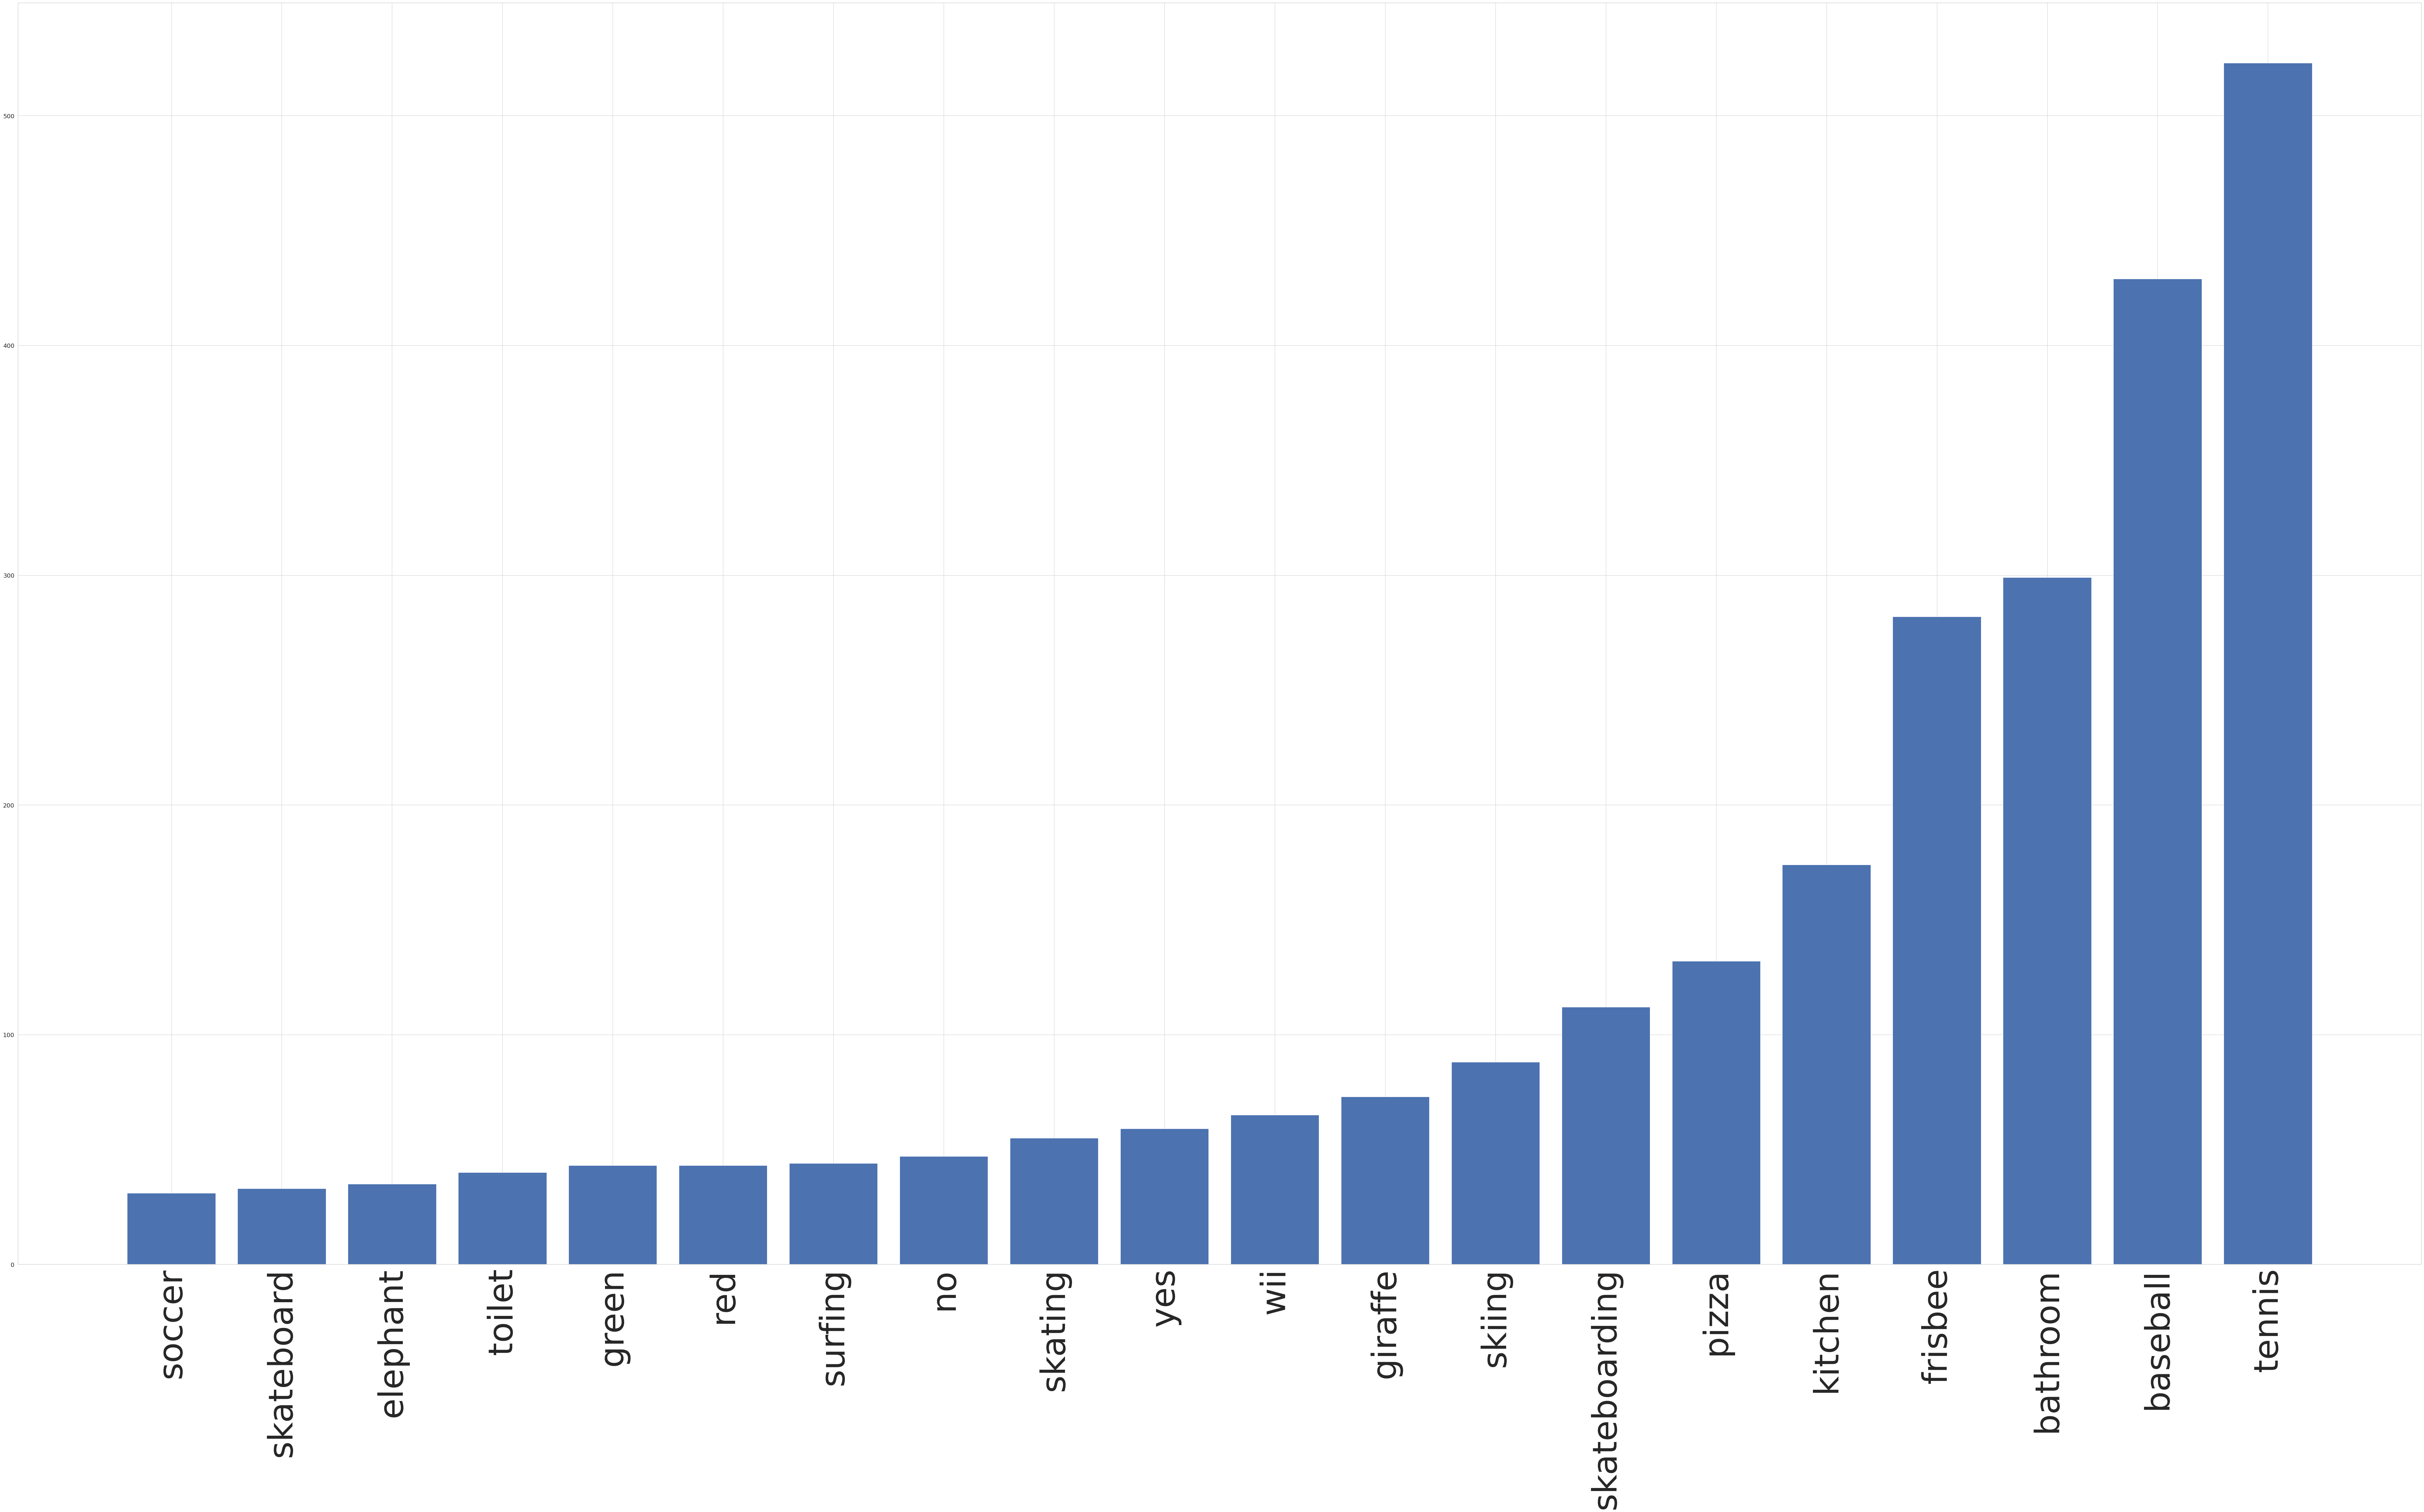

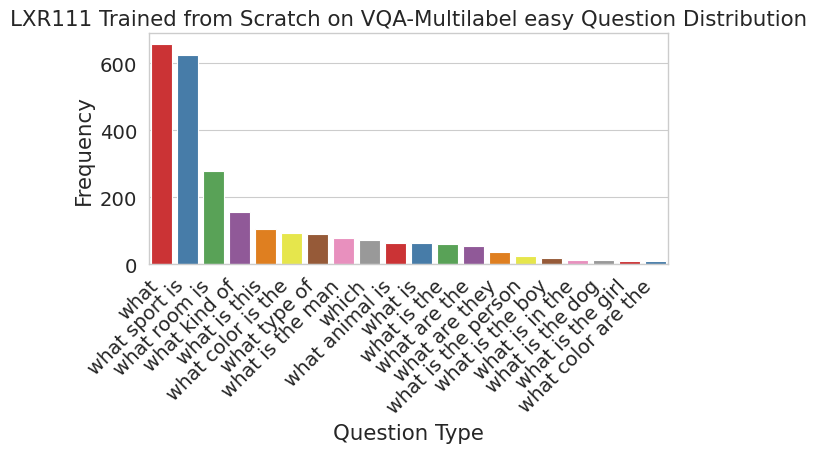

In [8]:
base_path_multilabel ='../snap/vqa/lxr111_multilabel_full_run_2/'
# #df_multilabel = load_datamap_stats(base_path_multilabel)
# df = calculate_datamap_metrics(base_path_multilabel, multilabel=True)
df = pd.read_pickle(base_path_multilabel+"datamap_metrics.pkl")
x = generate_region_distributions(base_path_multilabel, df, 'easy', title='LXR111 Trained from Scratch on VQA-Multilabel', conf_threshold=0.8, var_threshold=0.05, multilabel=True)
#scatter_it_interactive(df, base_path_multilabel, title='LXR111 VQA-Animals From Scratch - 20 epochs', show_hist=True)



<Figure size 5000x1000 with 0 Axes>

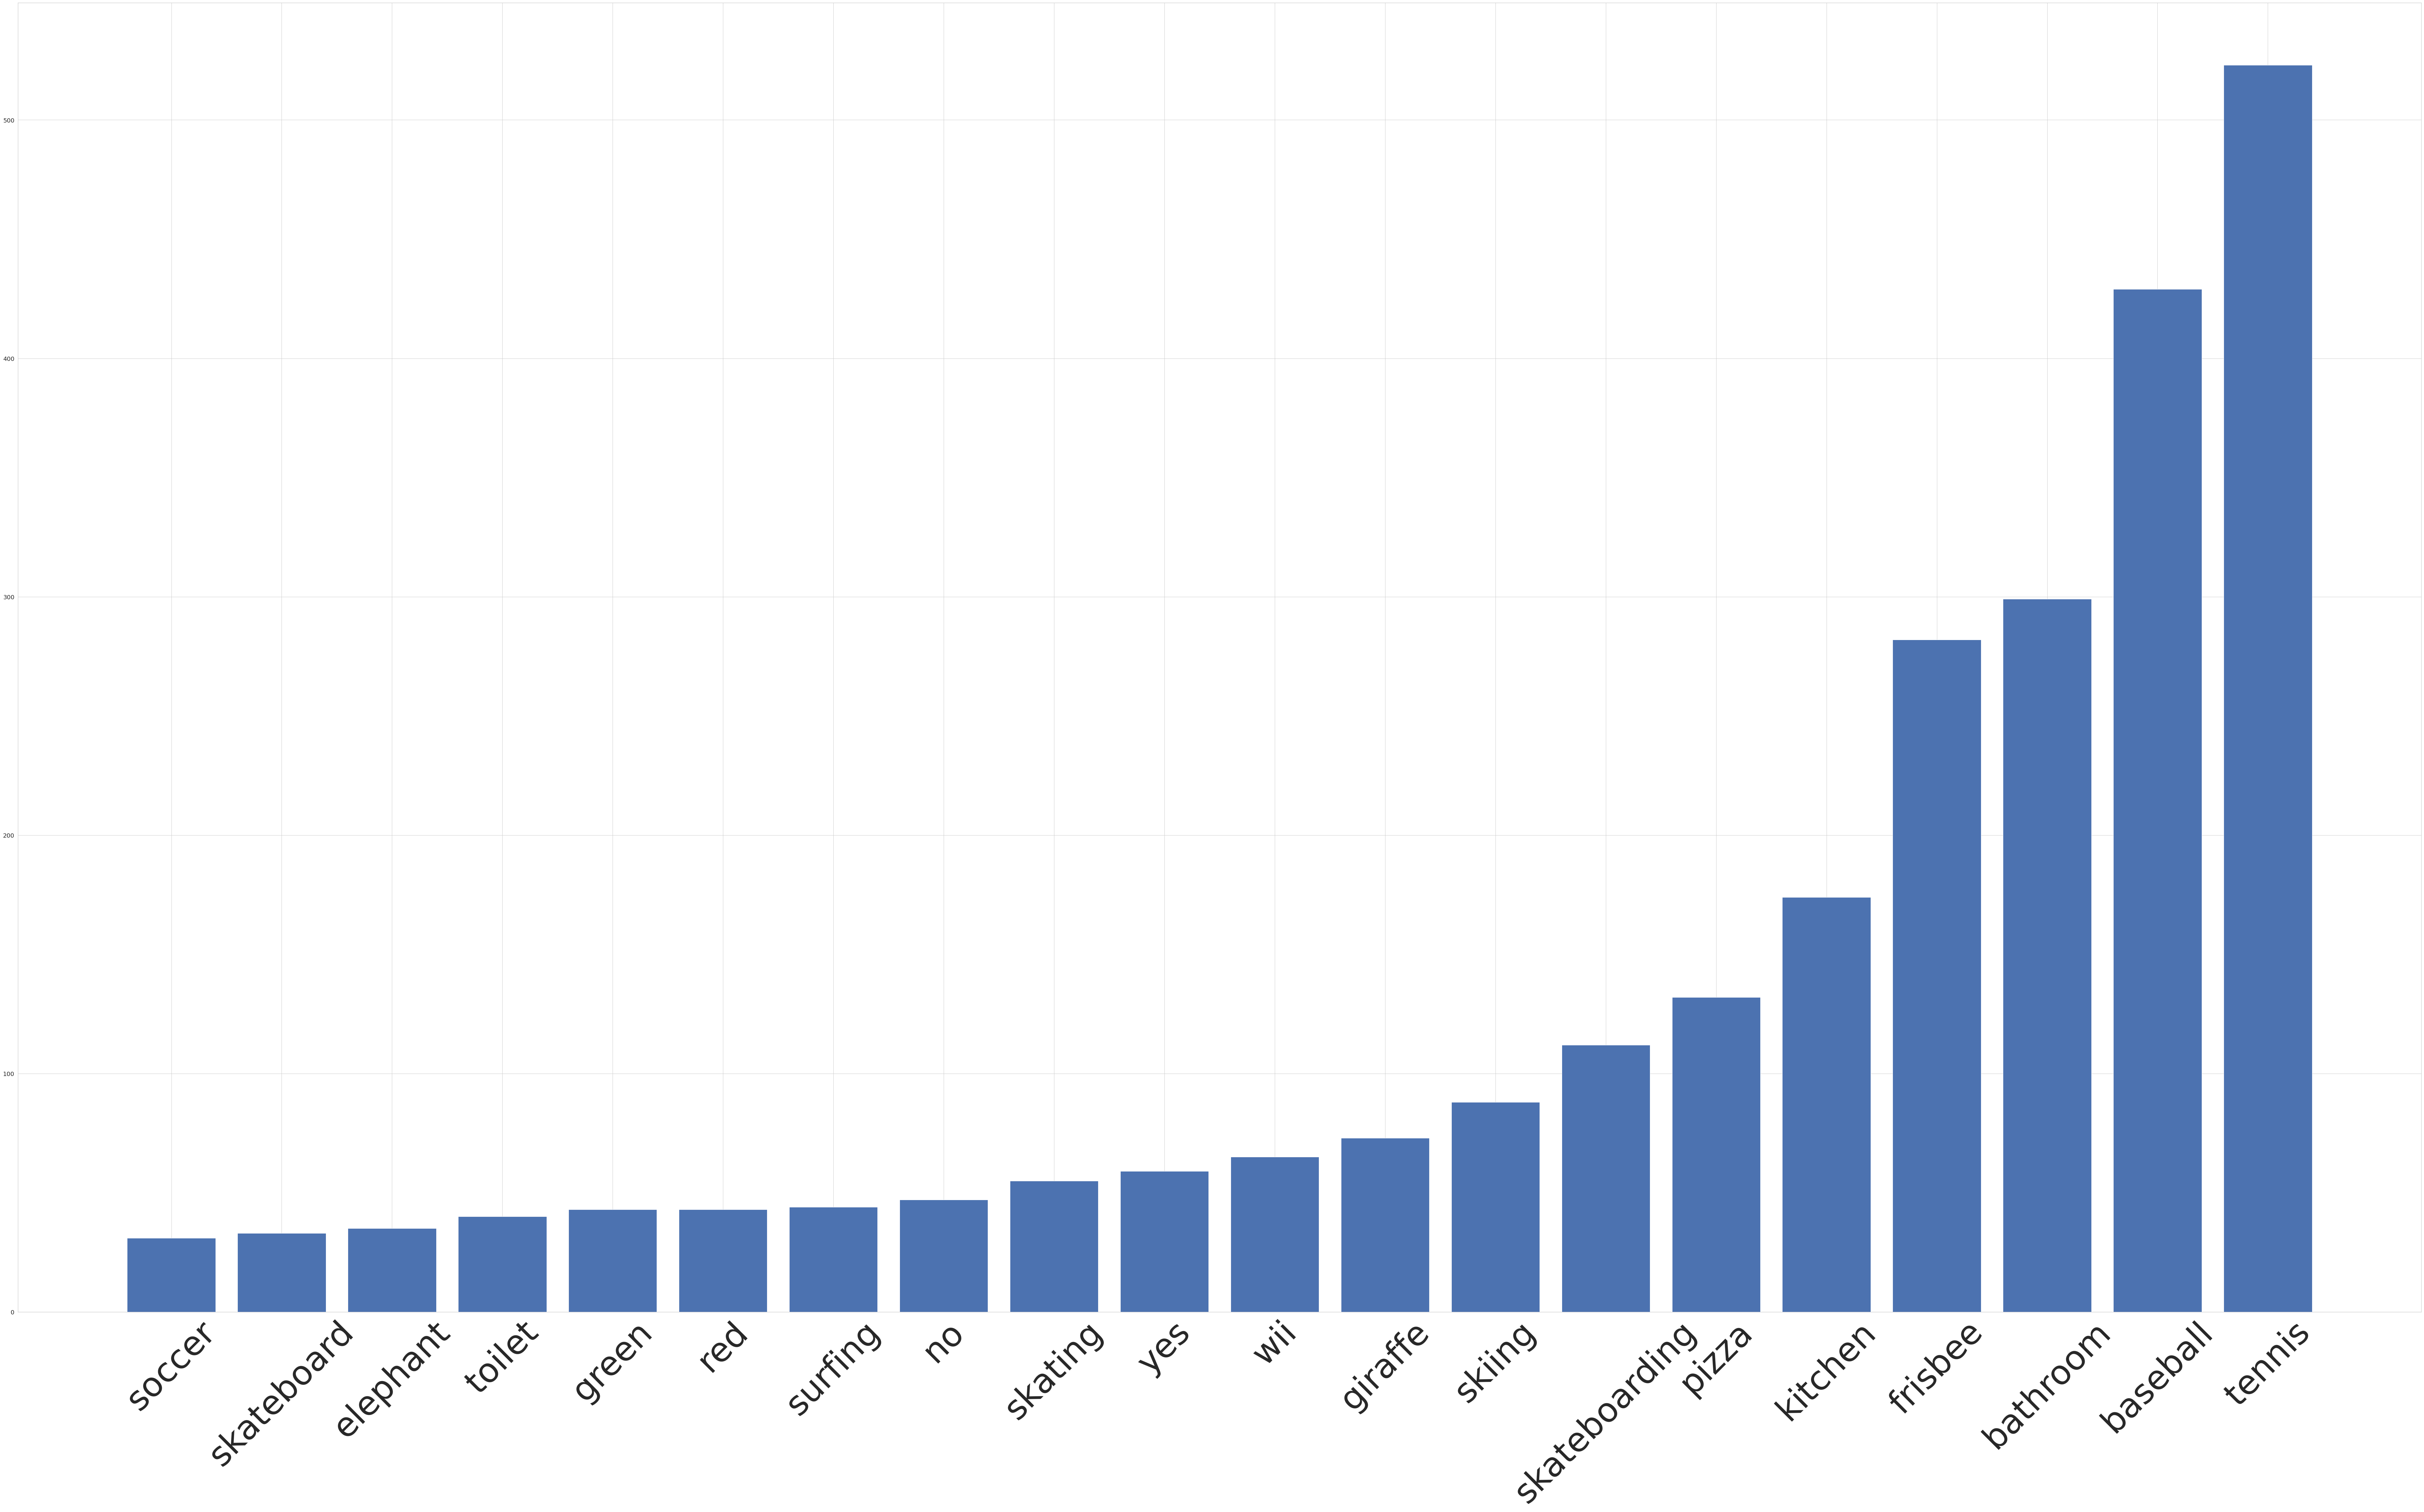

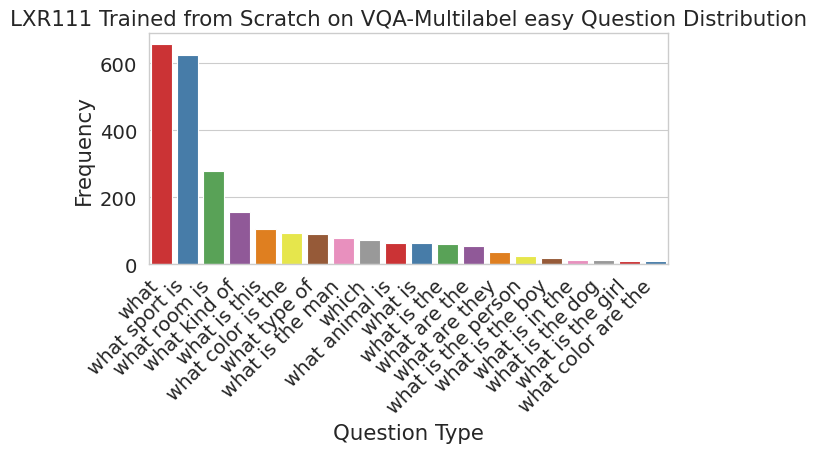

In [10]:
x = generate_region_distributions(base_path_multilabel, df, 'easy', title='LXR111 Trained from Scratch on VQA-Multilabel', conf_threshold=0.8, var_threshold=0.05, multilabel=True)


<Figure size 5000x1000 with 0 Axes>

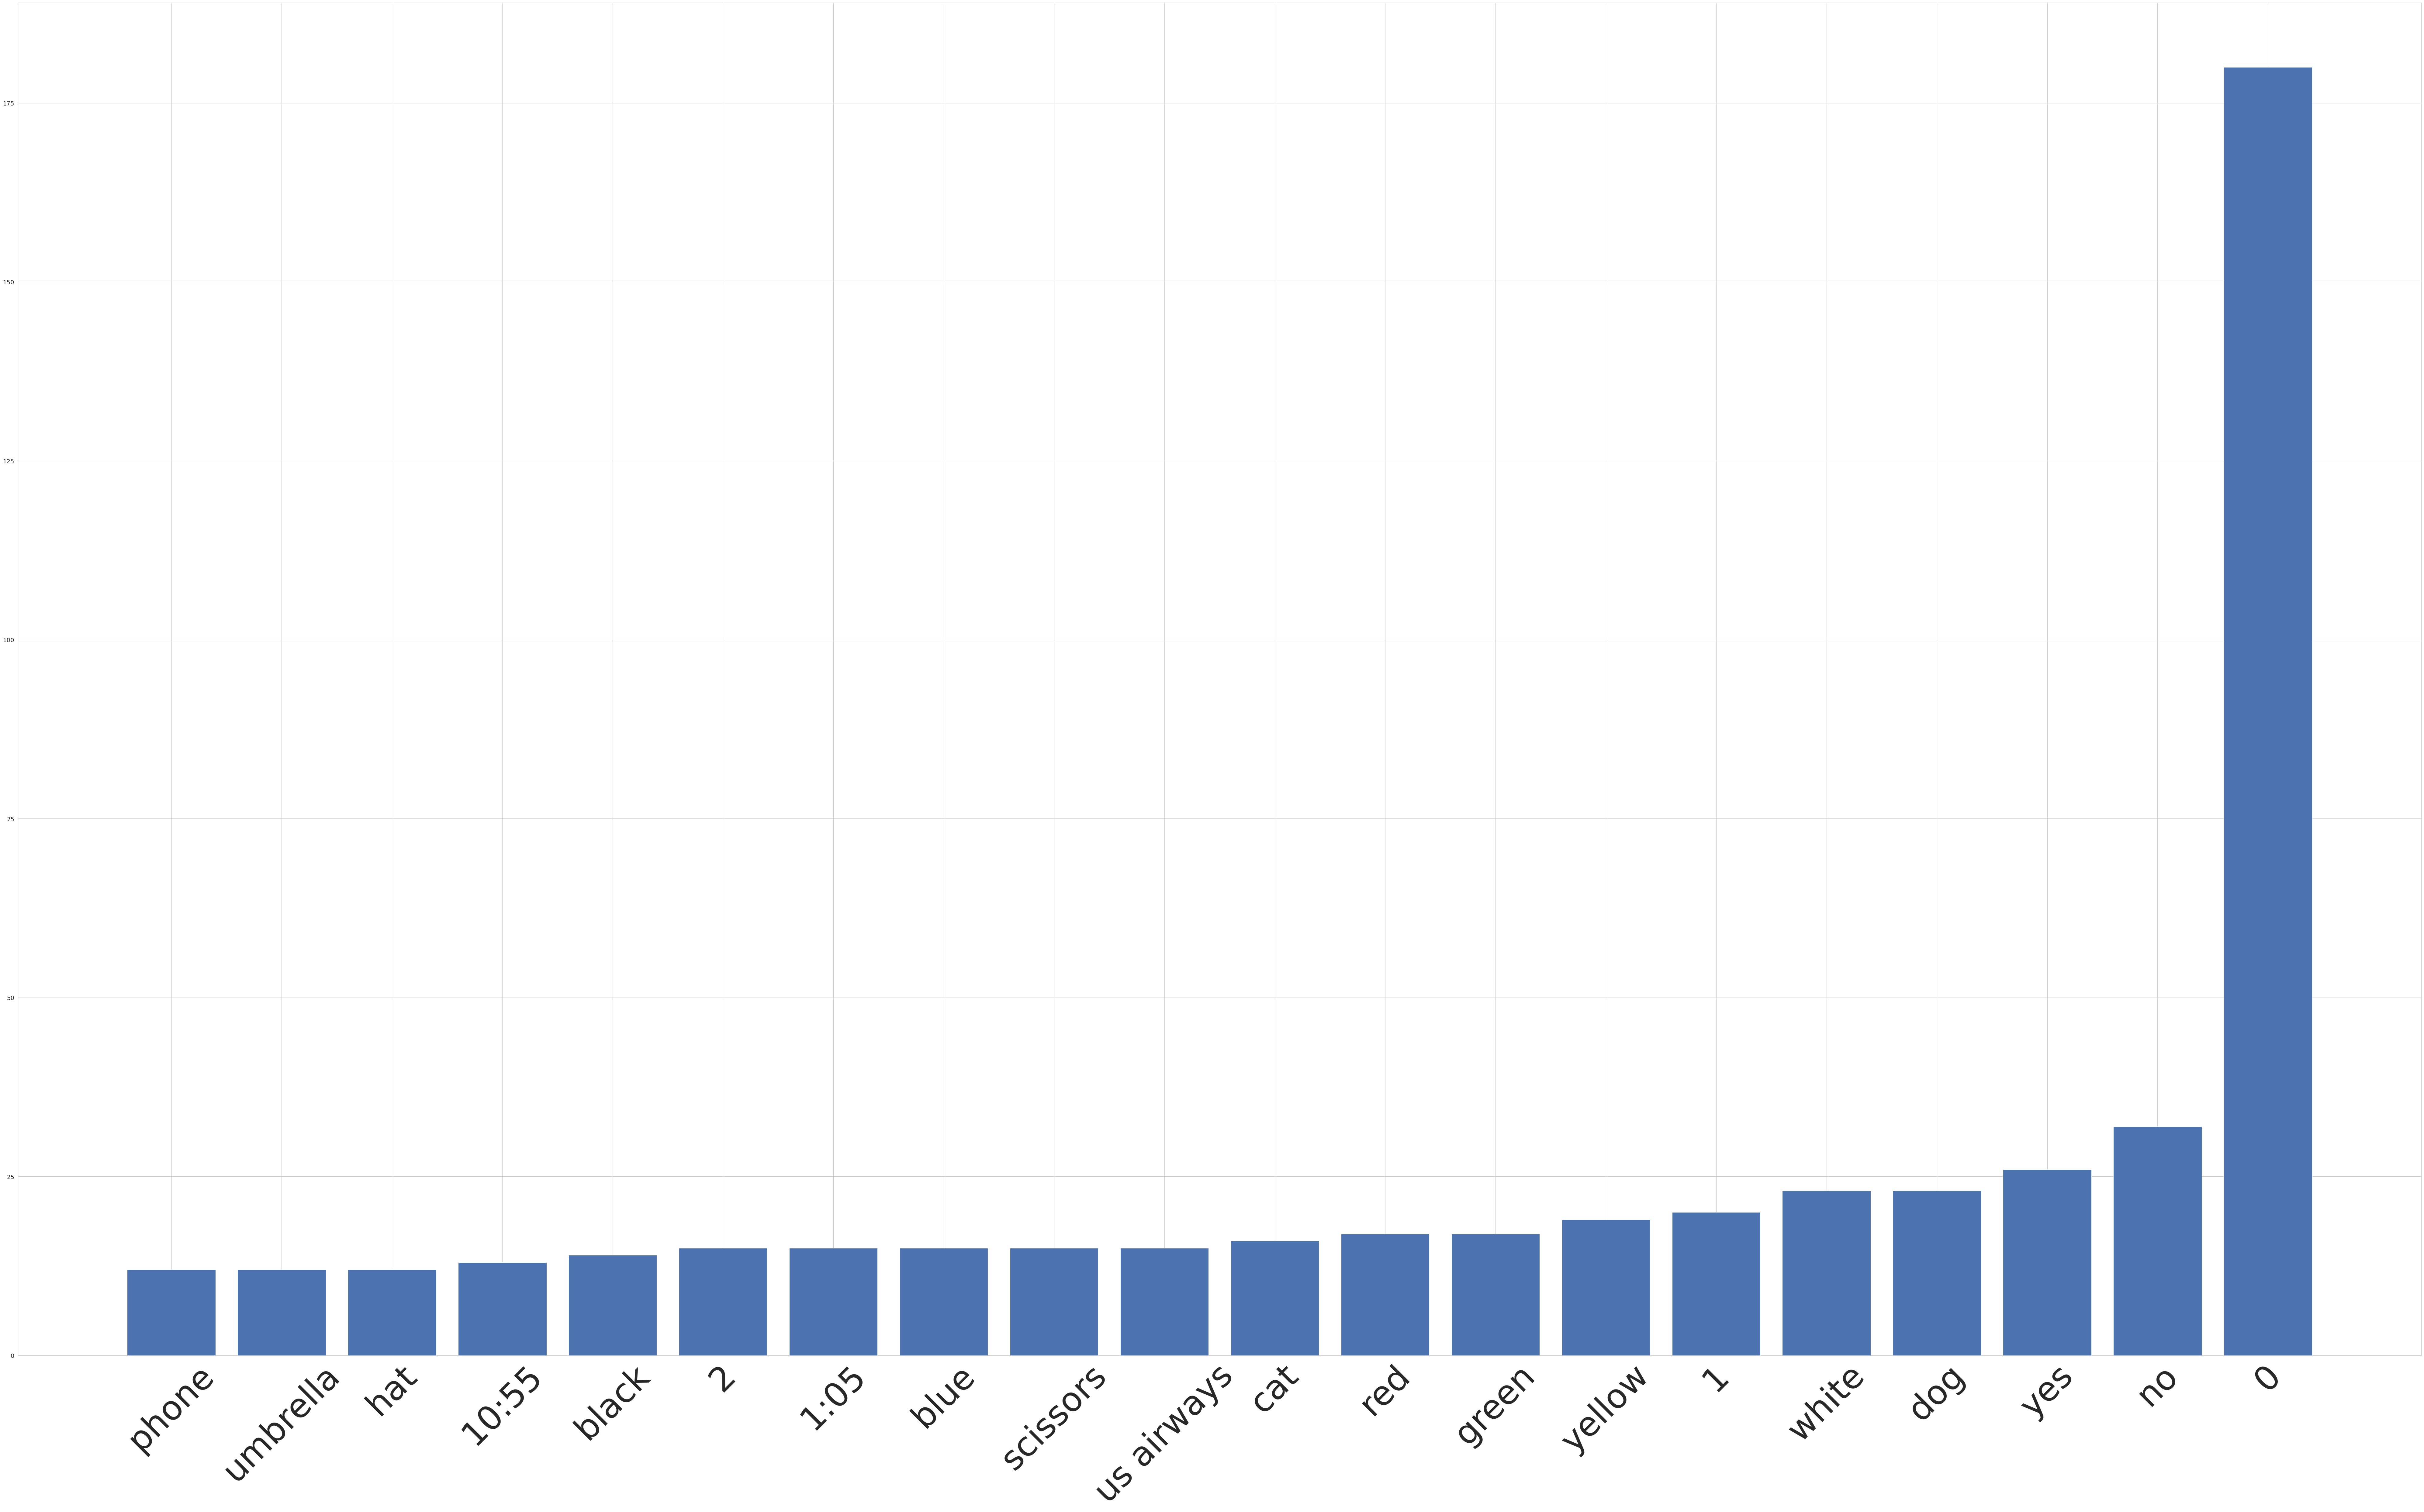

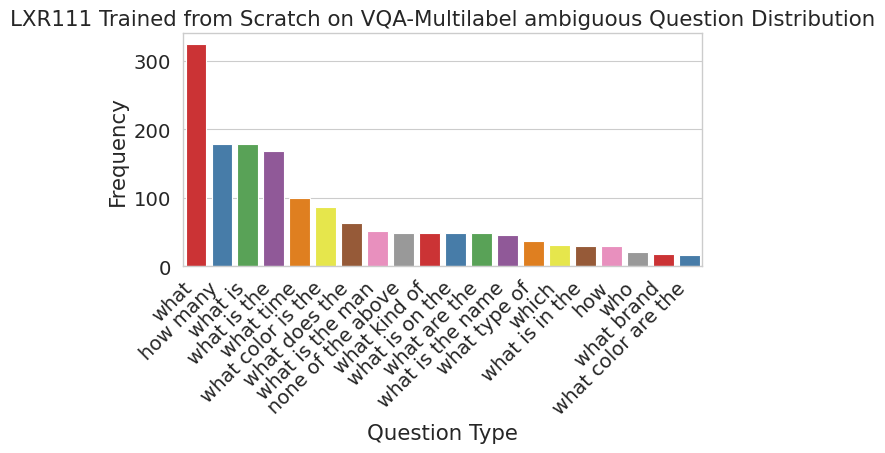

In [14]:



x = generate_region_distributions(base_path_multilabel, df, 'ambiguous', title='LXR111 Trained from Scratch on VQA-Multilabel', conf_threshold=0.4, var_threshold=0.38, multilabel=True)




<Figure size 5000x1000 with 0 Axes>

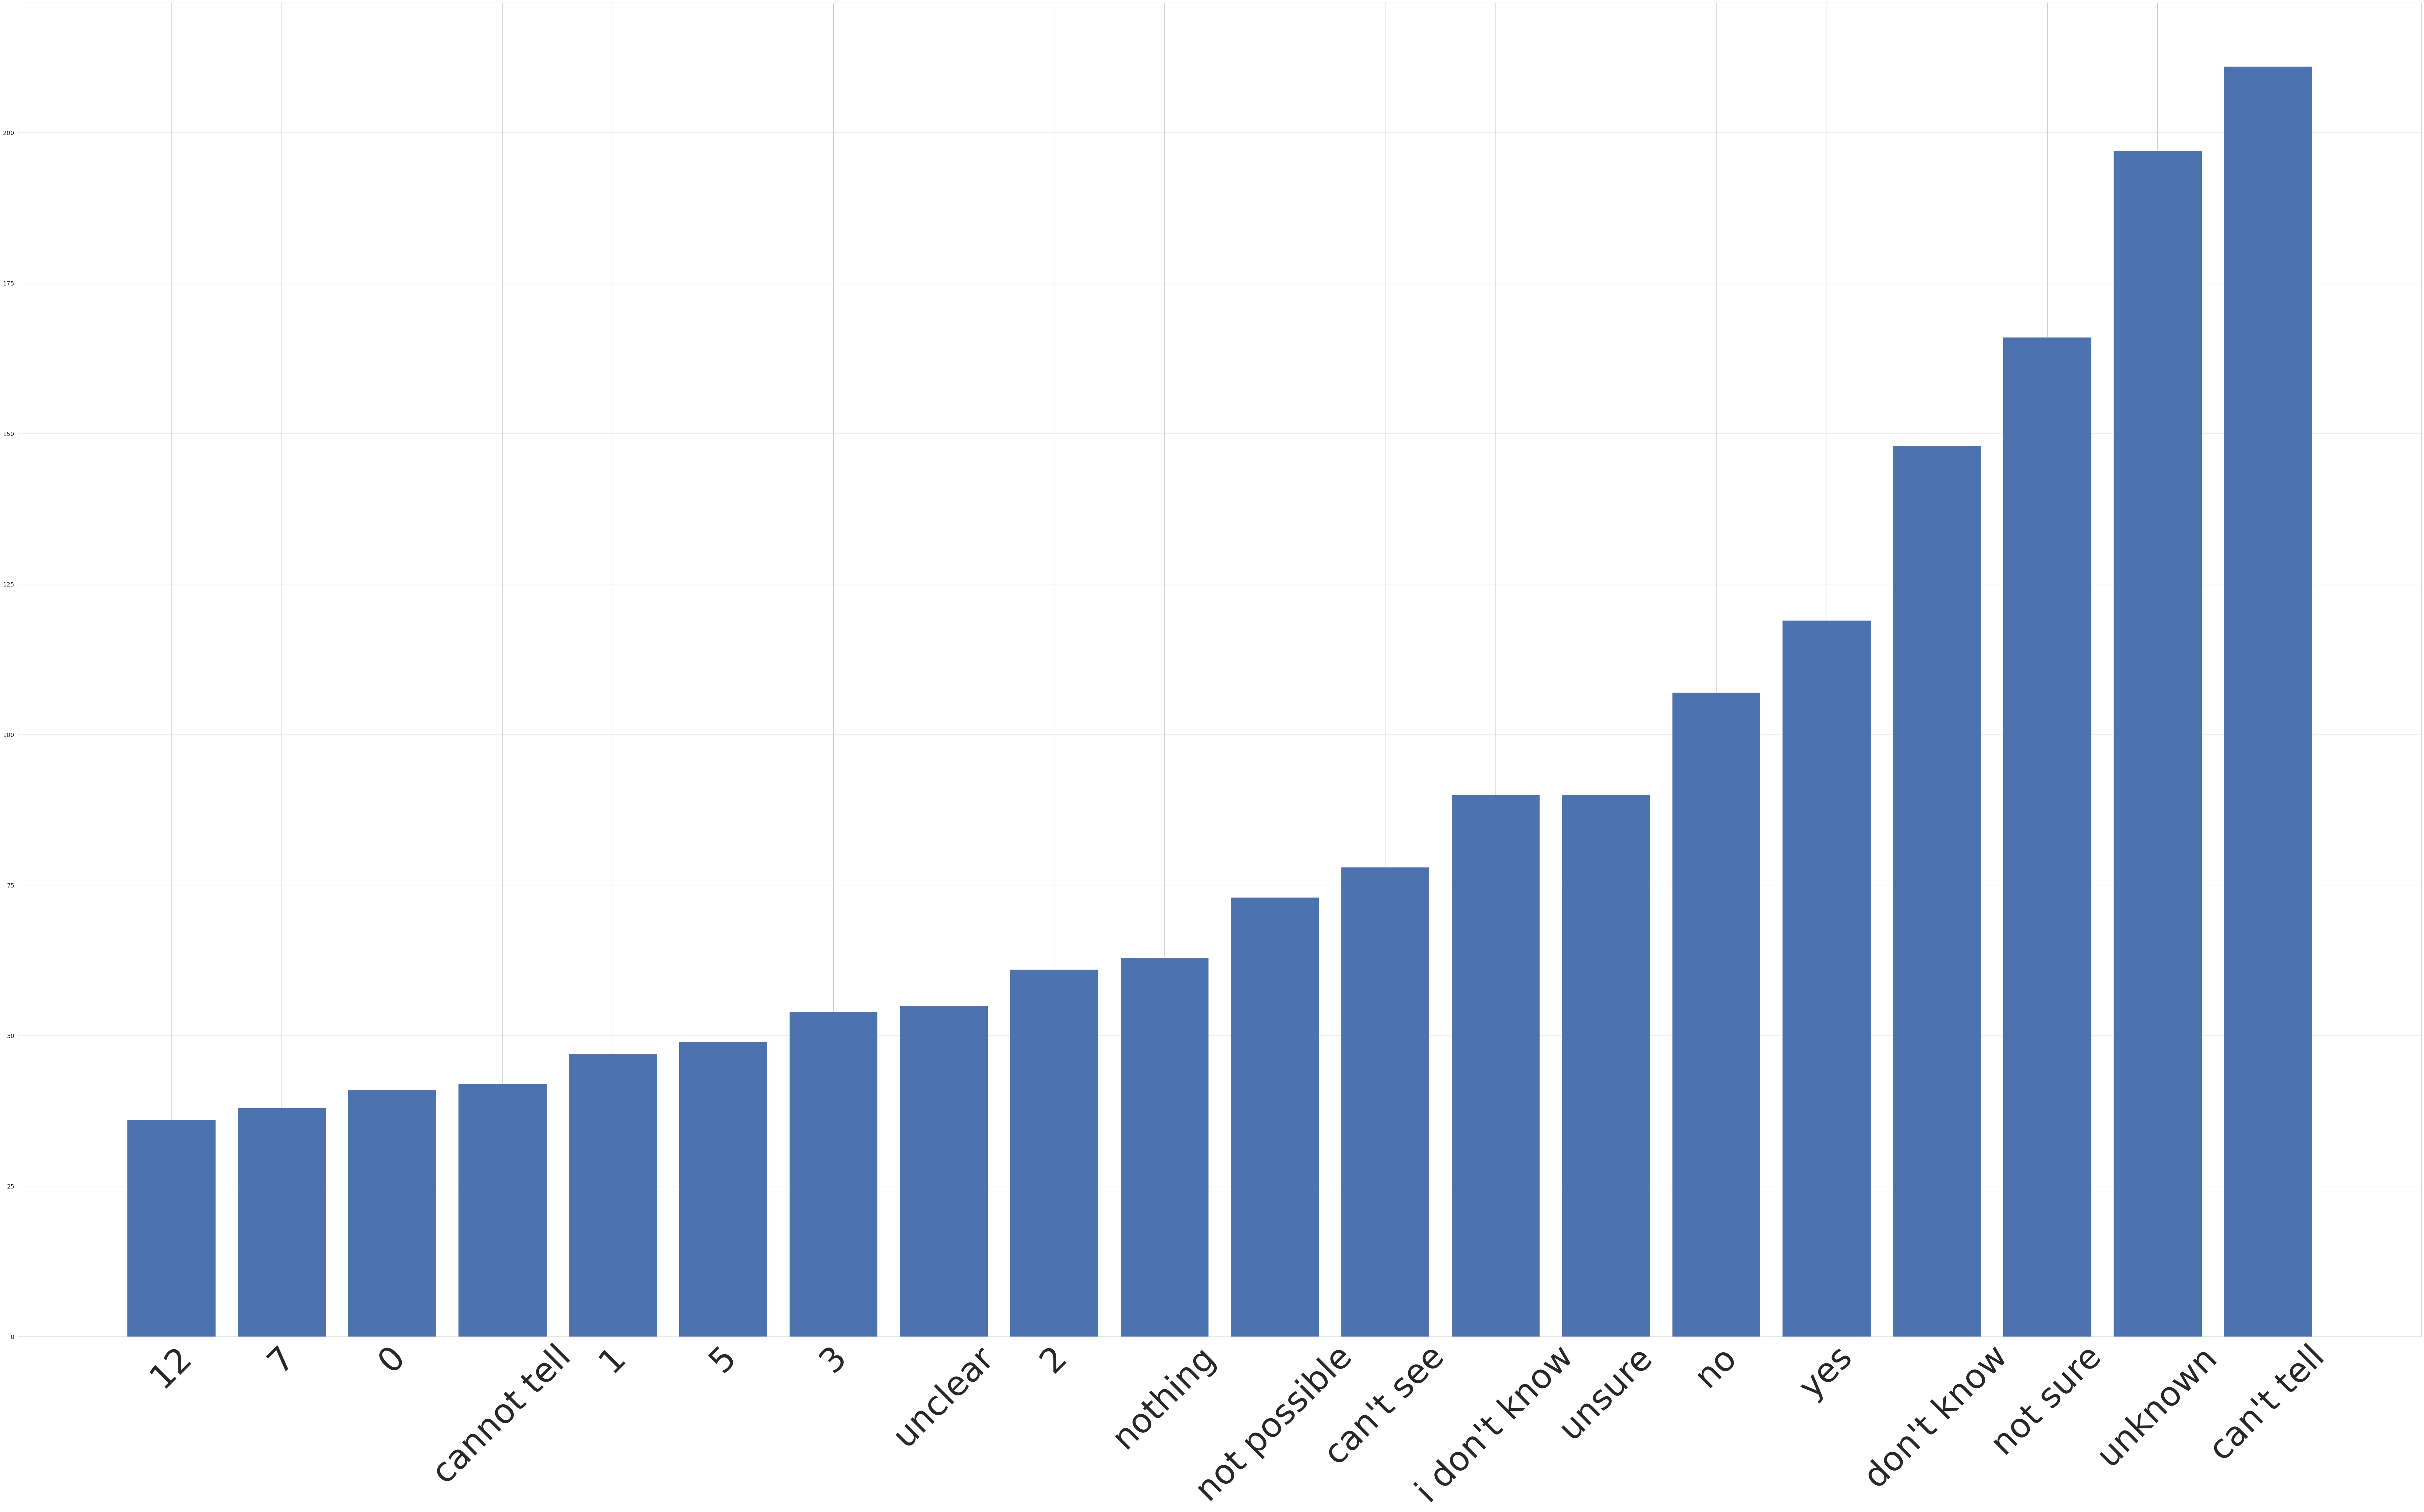

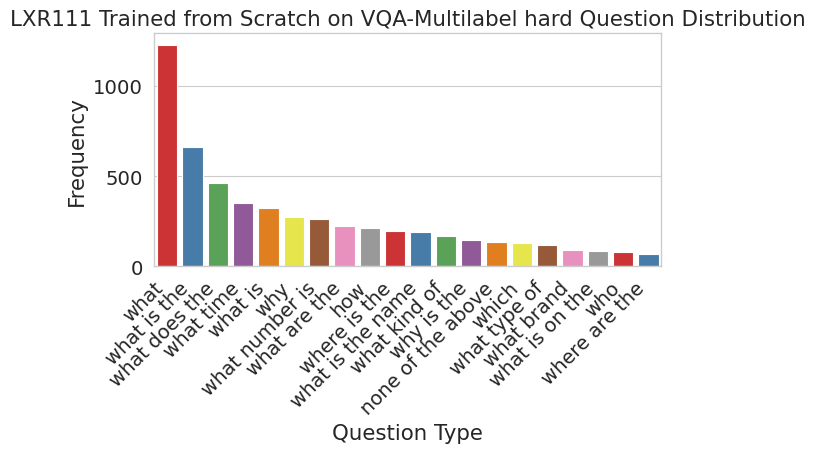

In [13]:
x = generate_region_distributions(base_path_multilabel, df, 'hard', title='LXR111 Trained from Scratch on VQA-Multilabel', conf_threshold=0.03, var_threshold=0.03, multilabel=True)


<Figure size 5000x1000 with 0 Axes>

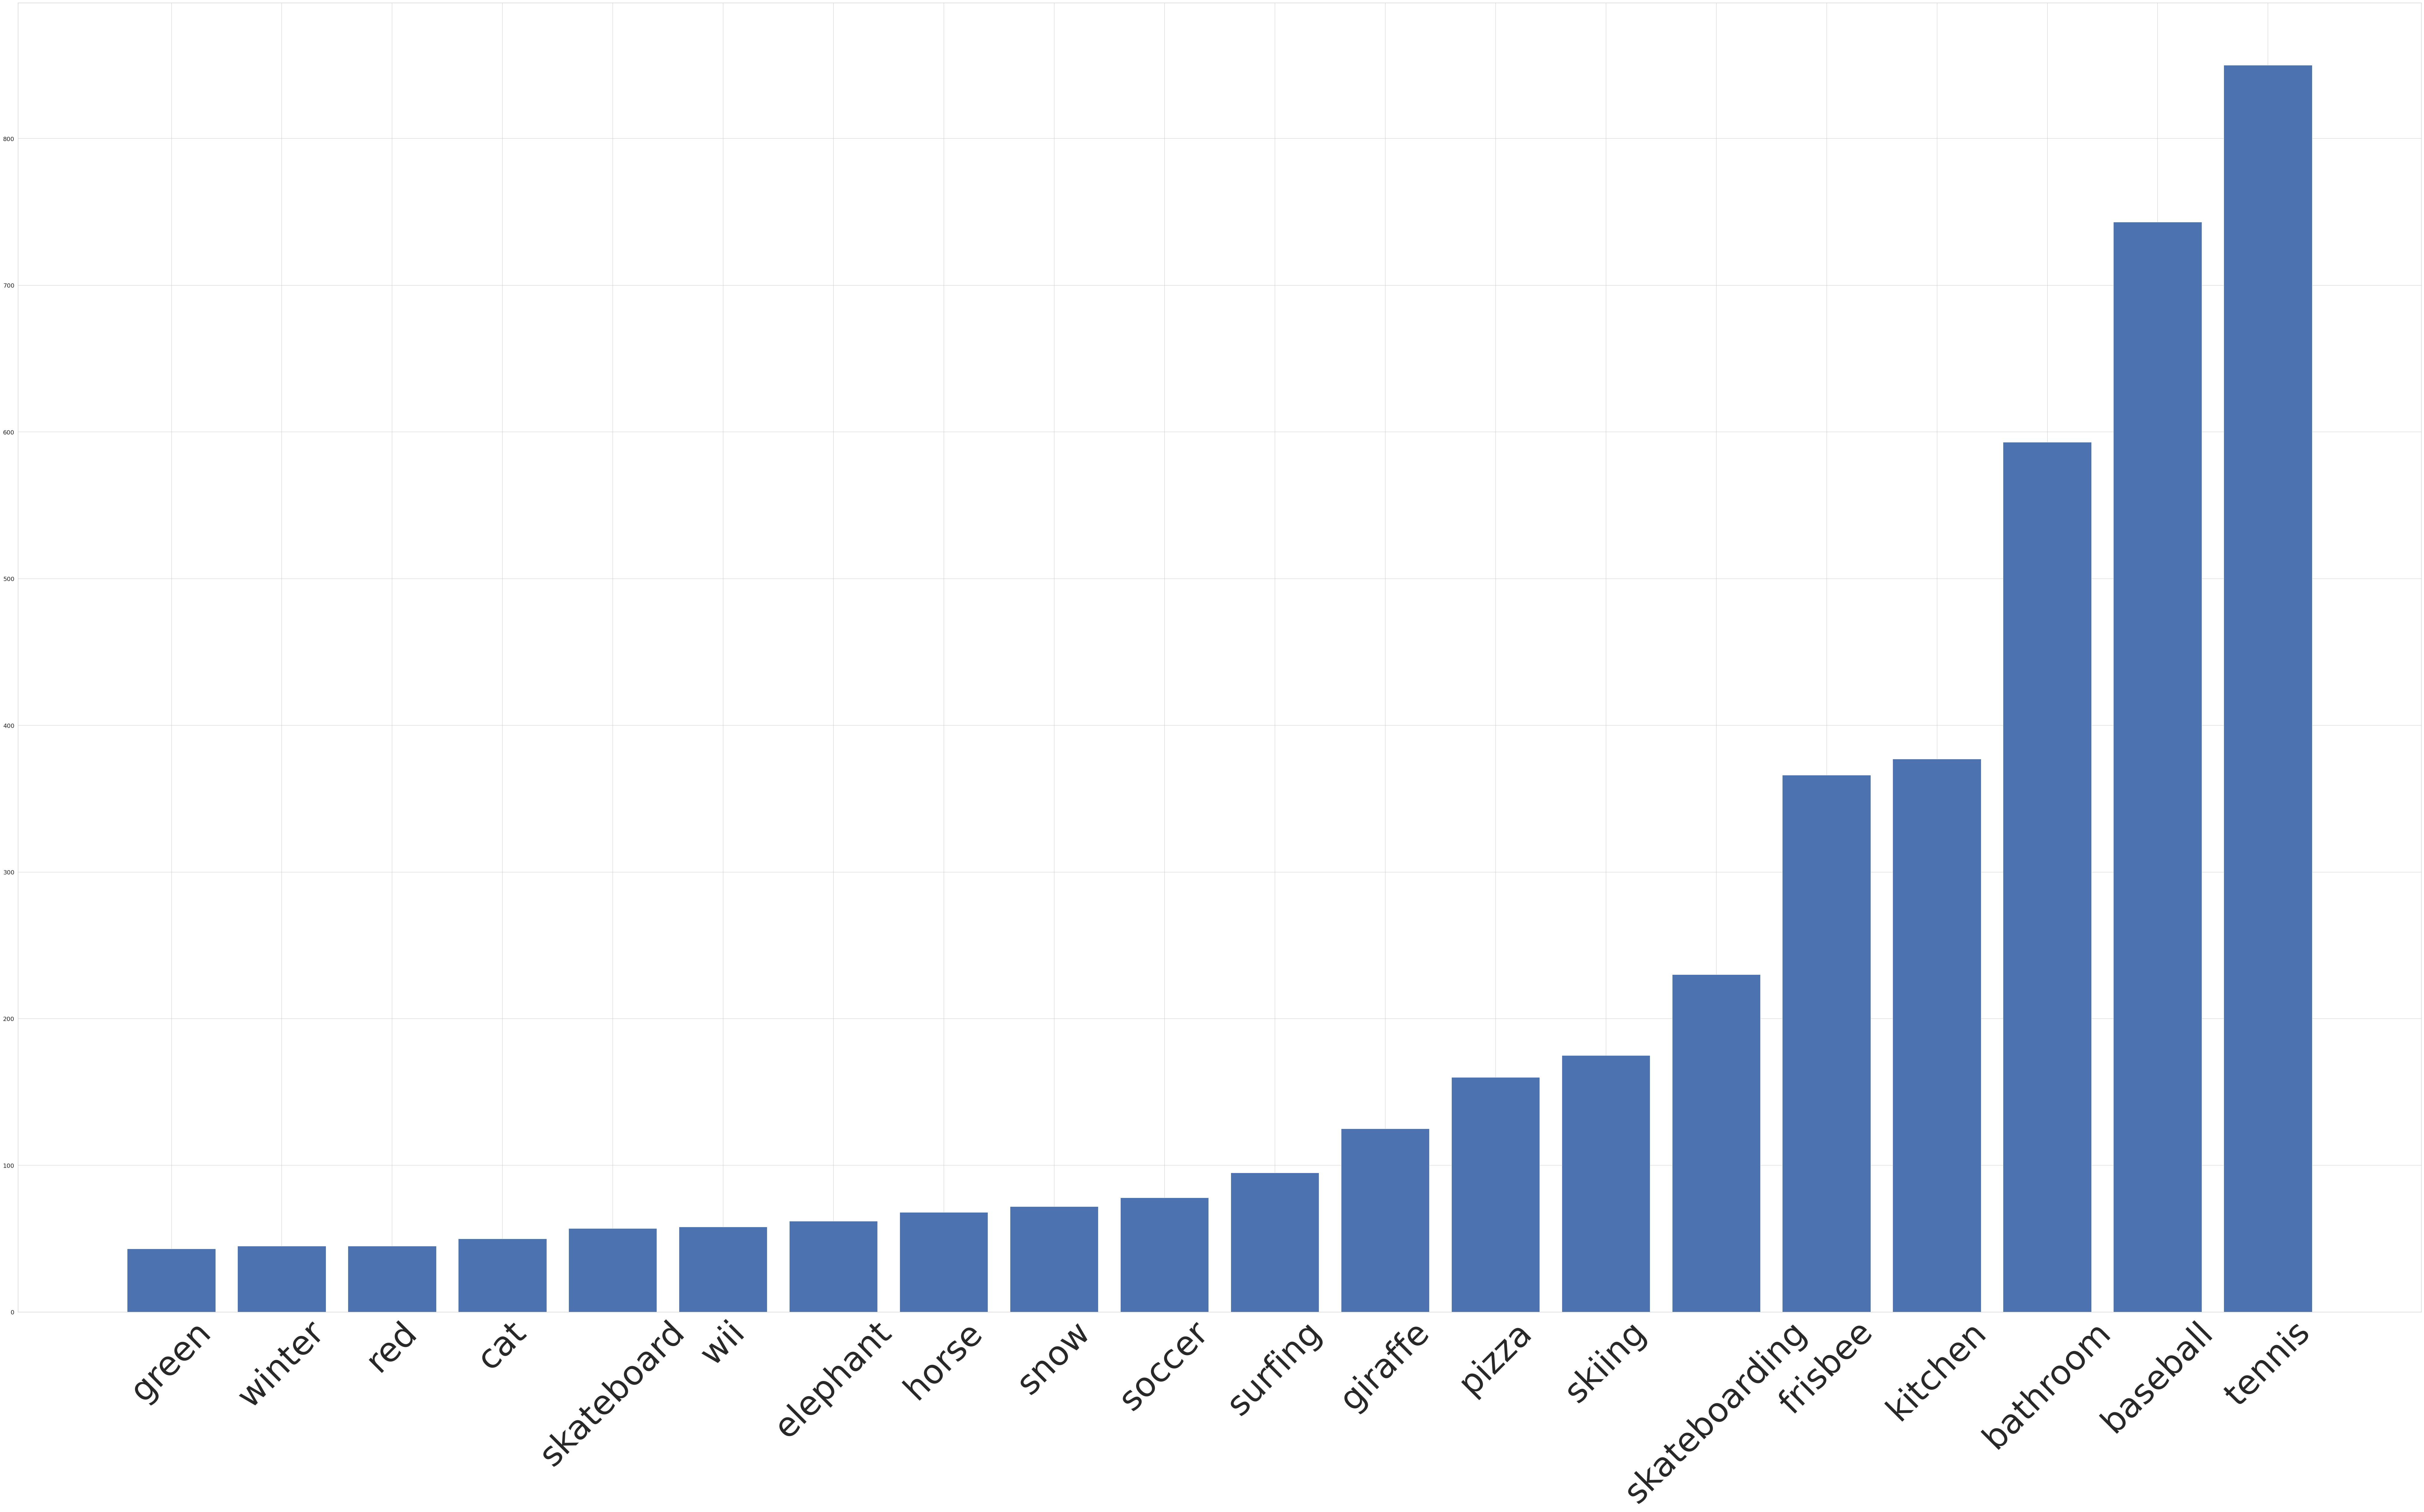

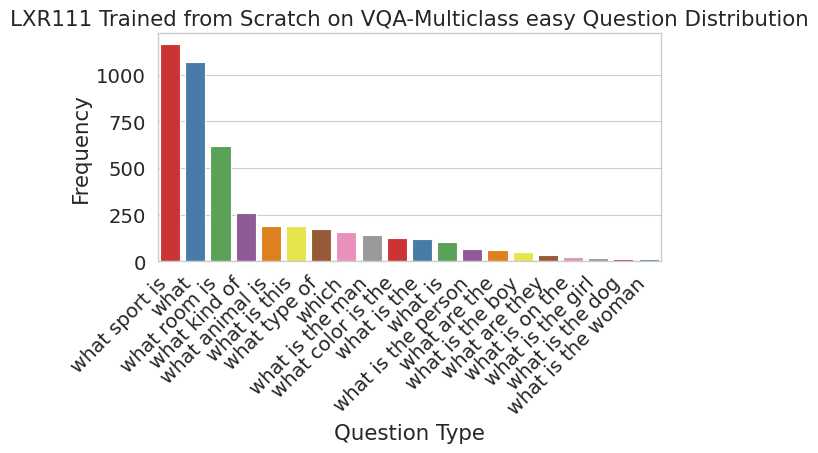

In [18]:
base_path='../snap/vqa/lxr111_multiclass_full_run_2/'
# #df_multilabel = load_datamap_stats(base_path_multilabel)
# df = calculate_datamap_metrics(base_path_multilabel, multilabel=True)
df = pd.read_pickle(base_path+"datamap_metrics.pkl")
x = generate_region_distributions(base_path, df, 'easy', title='LXR111 Trained from Scratch on VQA-Multiclass', conf_threshold=0.8, var_threshold=0.05, multilabel=False)
#scatter_it_interactive(df, base_path_multilabel, title='LXR111 VQA-Animals From Scratch - 20 epochs', show_hist=True)



<Figure size 5000x1000 with 0 Axes>

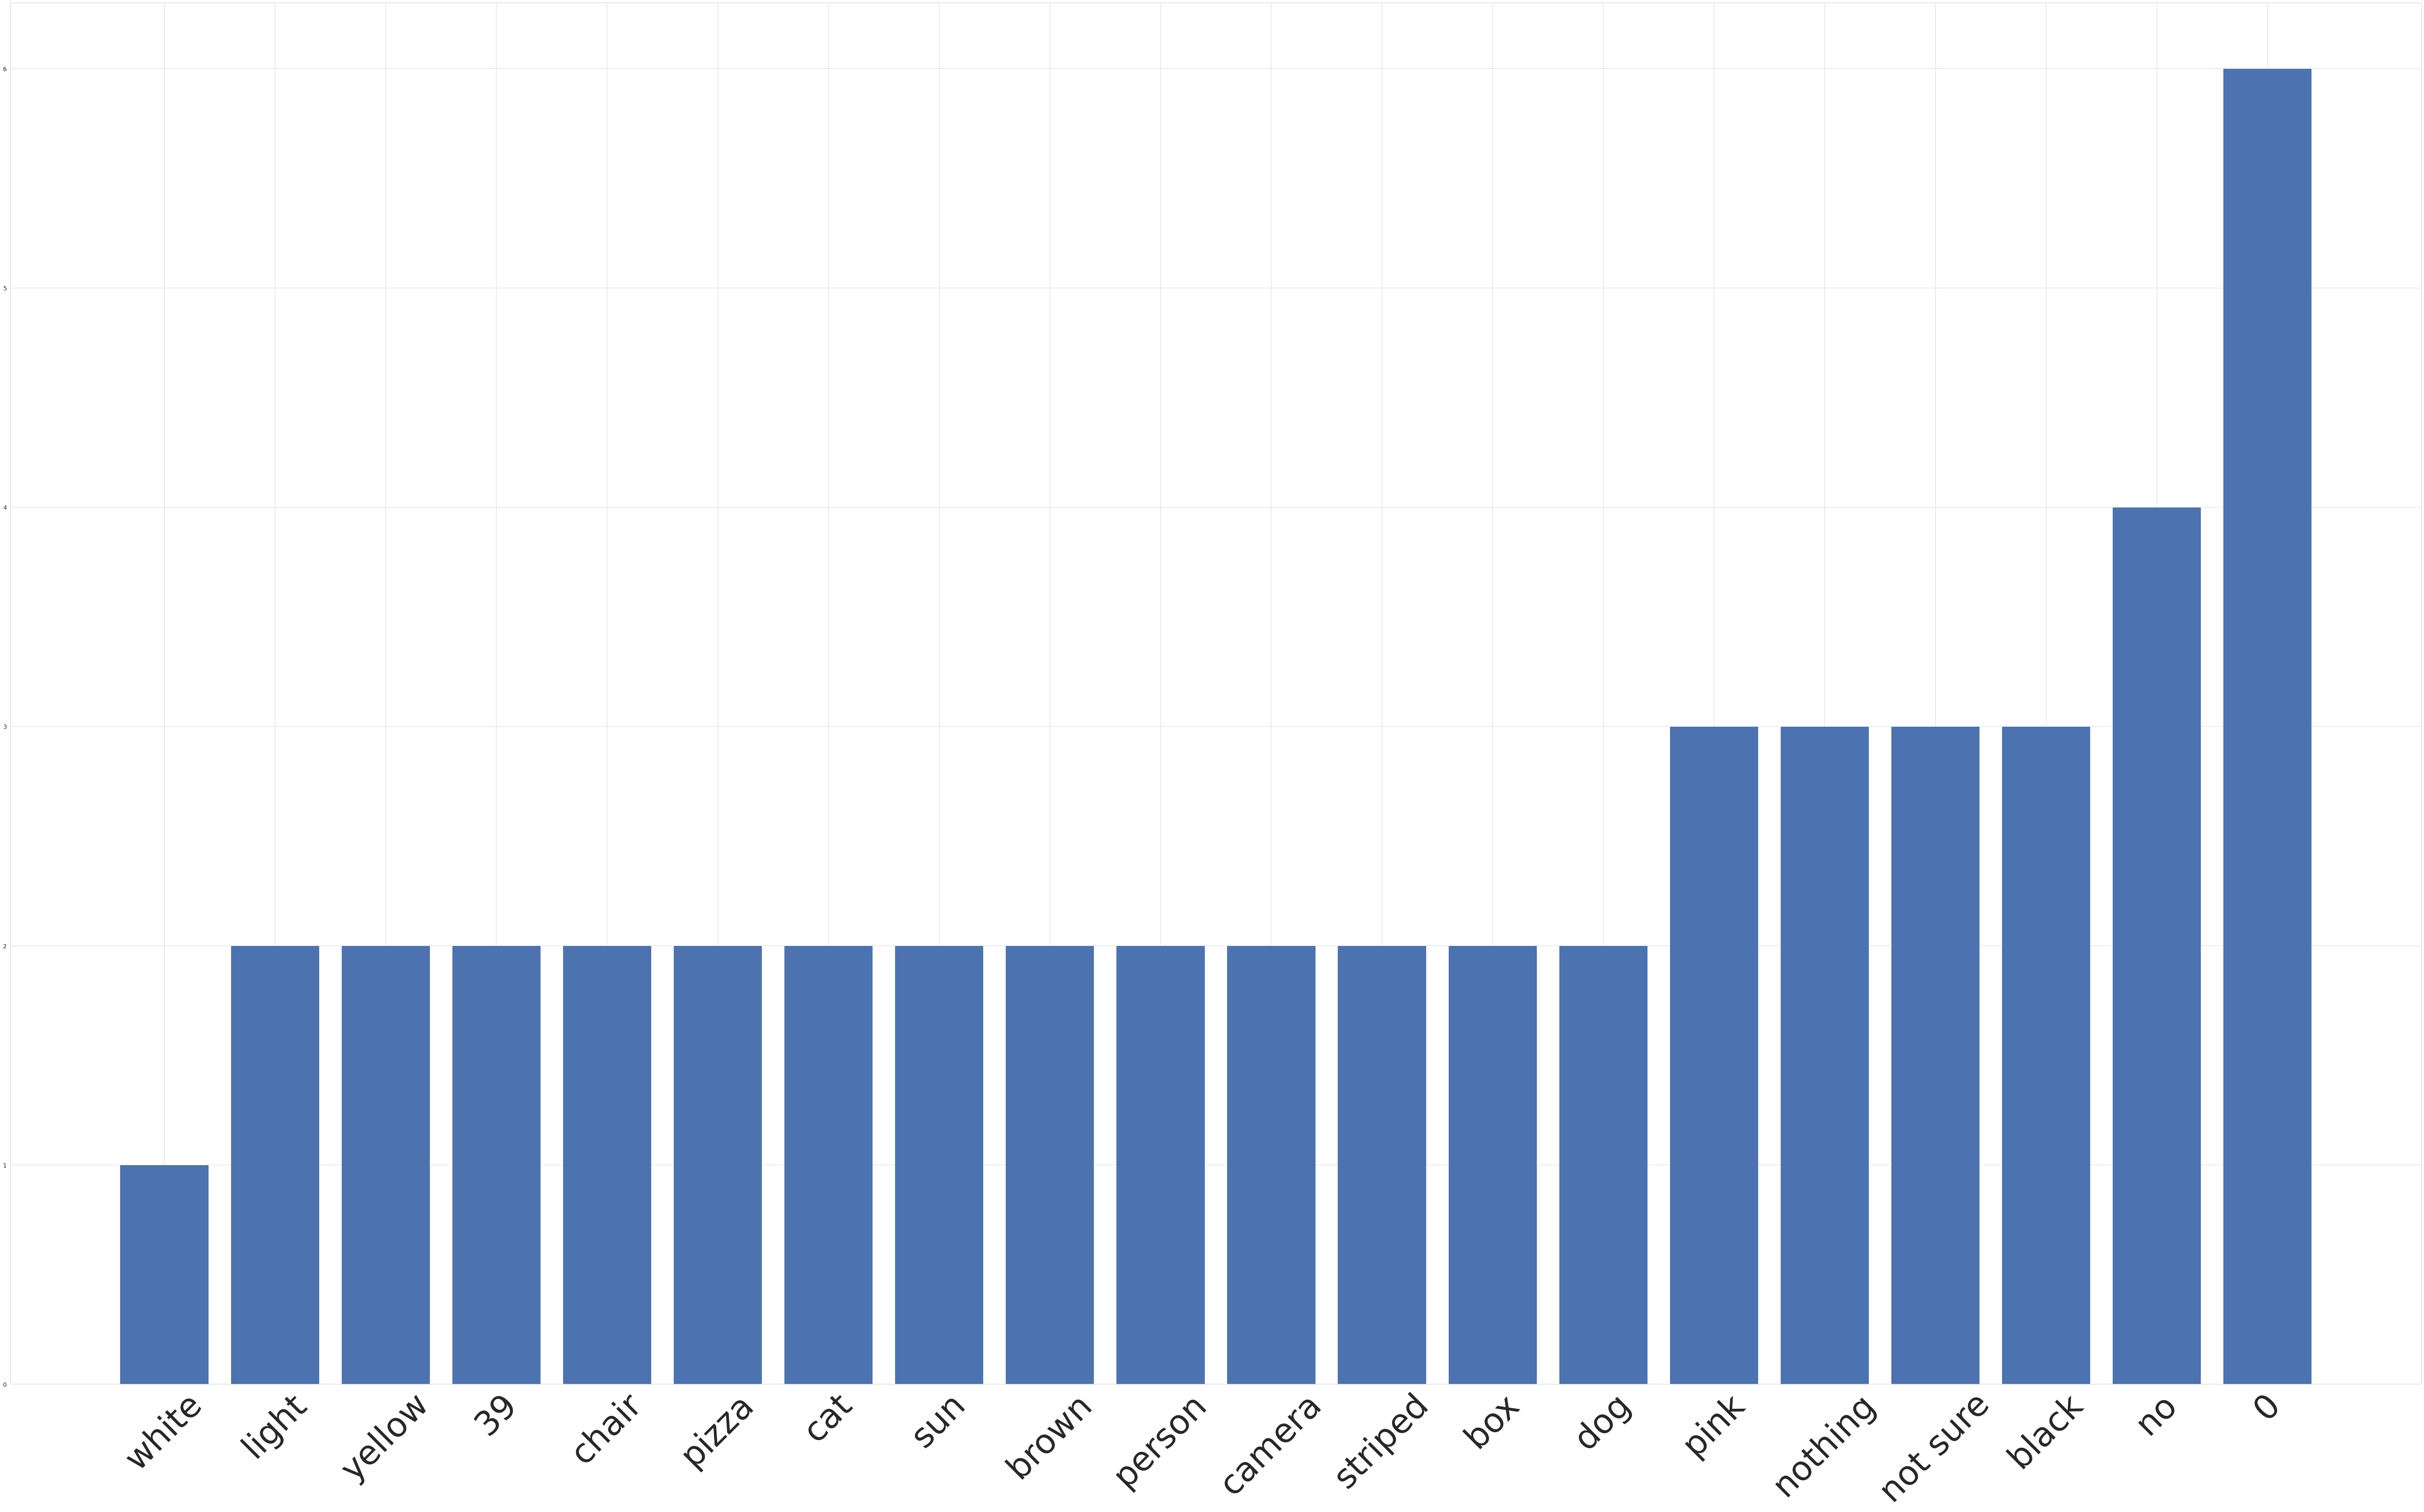

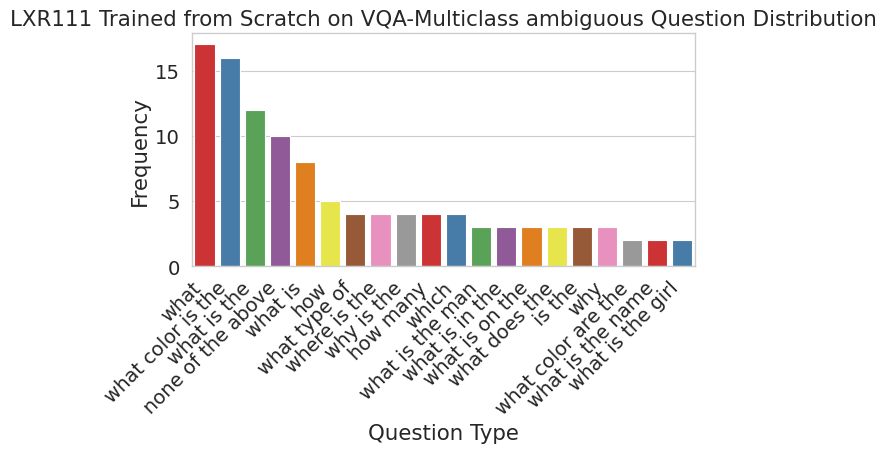

In [19]:
x = generate_region_distributions(base_path, df, 'ambiguous', title='LXR111 Trained from Scratch on VQA-Multiclass', conf_threshold=0.4, var_threshold=0.45, multilabel=False)


<Figure size 5000x1000 with 0 Axes>

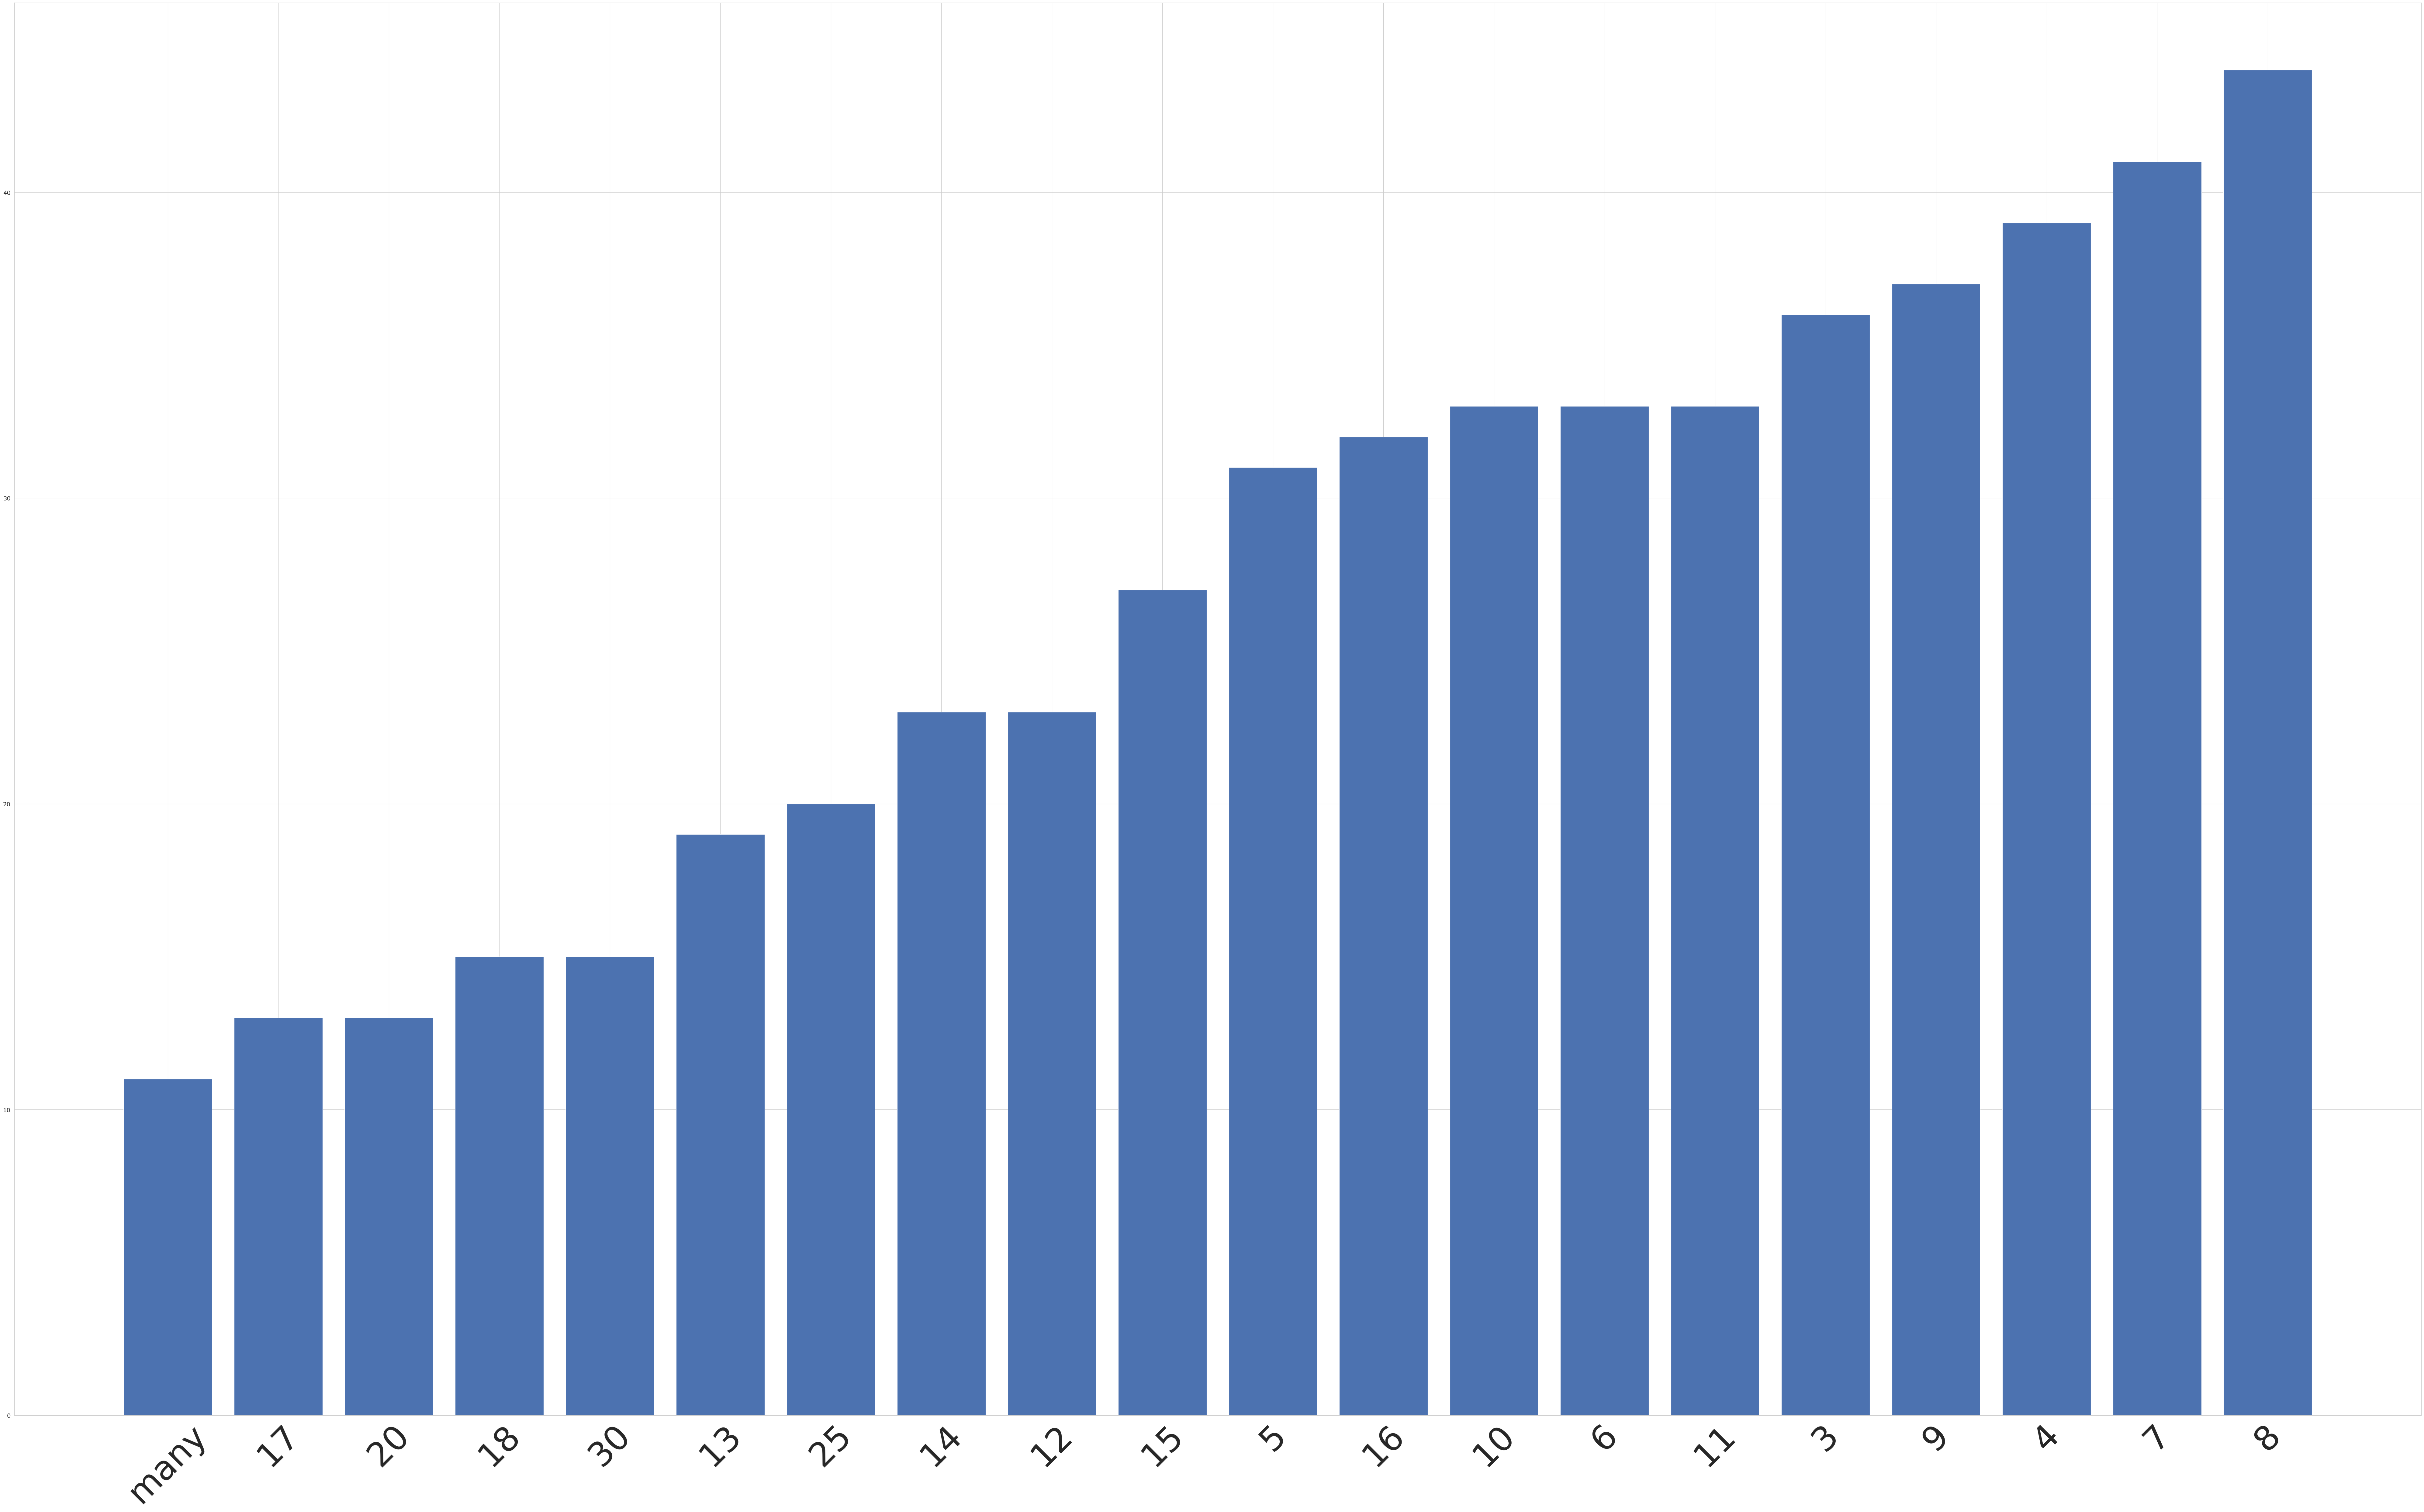

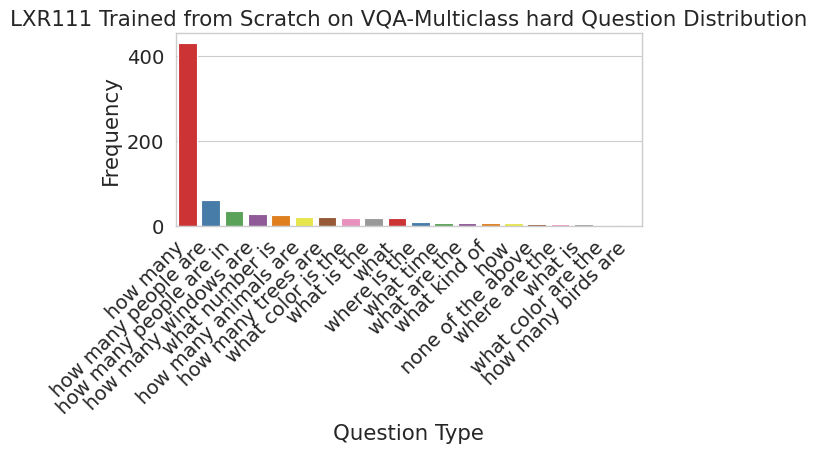

In [20]:
x = generate_region_distributions(base_path, df, 'hard', title='LXR111 Trained from Scratch on VQA-Multiclass', conf_threshold=0.2, var_threshold=0.05, multilabel=False)


# Investigate Target Label Distributions

In [ ]:
base_path_animals ='../snap/vqa/LXR111/animals/other/vqa_lxr111_animals_fromScratch_20epochs_breeds/'
df_animals = pd.read_pickle(base_path_animals+"datamap_metrics.pkl")


targets_animals = df_animals['Target'].tolist()
targets_animals = [i[0] for i in targets_animals]
df_animals['Target'] = targets_animals
targets_animals = df_animals['Target'].tolist()


animals_question_ids = df_animals['question_id'].tolist()

targets_multilabel =[]
for i in df_multilabel[0]:
    if i['Question ID'] in animals_question_ids:
        target_list = [x.strip() for x in i['Target'].split(',')]
        targets_multilabel.extend(target_list)


plt.figure(figsize=(80,50))
# Set the figure size
plt.rcParams["figure.autolayout"] = True
multiclass_animals = freq(targets_animals)
plt.bar(multiclass_animals.keys(), multiclass_animals.values())
plt.xticks(rotation='vertical', fontsize=10)


plt.figure(figsize=(80,50))
# Set the figure size
plt.rcParams["figure.autolayout"] = True
multilabel_animals = freq(targets_multilabel)
plt.bar(multilabel_animals.keys(), multilabel_animals.values())
plt.xticks(rotation='vertical', fontsize=10)